<a href="https://colab.research.google.com/github/dev-ago-uy/ExamenM-duloII.DM/blob/main/Examen_II_WA_DanielMendiola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examen Práctico II – Predicción de Precios de Propiedades


* Fecha de ejecución: Junio 2025

# Autor

Ing. Daniel Mendiola



**Objetivo**

Predecir el precio de casas utilizando un dataset provisto (disponible en GitHub). Aunque el dataset original contiene imágenes, no es necesario utilizarlas para este examen.

Fecha: Junio 2025

# Datos

x : https://raw.githubusercontent.com/AnIsAsPe/WA_ModuloII_DatosExamen/refs/heads/main/Datos/X.csv

y : https://raw.githubusercontent.com/AnIsAsPe/WA_ModuloII_DatosExamen/refs/heads/main/Datos/y.csv




# Introducción



**Predicción del precio de propiedades a partir de características estructurales y energéticas**

Este notebook tiene como objetivo desarrollar y evaluar un modelo de aprendizaje automático capaz de predecir el precio de viviendas, utilizando información tabular relacionada con sus características físicas, energéticas y de localización.

Durante el proceso se abordarán las siguientes etapas:

- Exploración y limpieza del dataset: detección de valores faltantes, análisis de variables numéricas y categóricas.
- Análisis de correlaciones: para identificar las variables más influyentes en el precio.
- Ingeniería de variables: selección, escalado y generación opcional de componentes polinomiales.
- Entrenamiento de modelos: se implementará una regresión lineal base y un modelo de regresión robusta (Huber) para comparar resultados.
- Evaluación y visualización: mediante métricas como R², MAE y análisis gráfico de predicciones.
- Interpretación de resultados: se valorará la precisión y la robustez frente a valores extremos, sin perder interpretabilidad.

El foco estará puesto en construir un modelo predictivo confiable y explicativo, capaz de capturar patrones del mercado inmobiliario en función de las variables disponibles.


# Diccionario de Términos

A continuación se presenta un glosario breve de los términos clave utilizados en el desarrollo del modelo:

- **Regresión Lineal**: Técnica estadística que modela la relación entre una variable dependiente (precio) y una o más variables independientes mediante una línea recta.

- **Regresión de Huber**: Variante robusta de la regresión lineal que reduce la sensibilidad a valores atípicos (outliers), combinando la función de pérdida cuadrática con la lineal.

- **R² (Coeficiente de determinación)**: Mide qué proporción de la varianza de la variable objetivo es explicada por el modelo. Un valor cercano a 1 indica buen ajuste.

- **MAE (Mean Absolute Error)**: Error absoluto medio. Indica cuánto se equivoca en promedio el modelo al predecir, sin penalizar grandes errores.

- **MSE (Mean Squared Error)**: Error cuadrático medio. Penaliza más fuertemente los errores grandes, útil para detectar dispersión.

- **Outlier**: Valor atípico que se aleja considerablemente del resto de los datos. Puede afectar negativamente los modelos sensibles.

- **Imputación**: Proceso de reemplazar valores faltantes con estimaciones como la media, mediana o moda.

- **Escalado (StandardScaler)**: Transformación de variables numéricas para que tengan media 0 y desviación estándar 1. Mejora el rendimiento de algunos algoritmos.

- **Polinomios (PolynomialFeatures)**: Ampliación de las variables mediante términos no lineales (cuadrados, productos), útil para capturar relaciones más complejas.

- **Correlación de Pearson**: Medida de la relación lineal entre dos variables. Va de -1 (correlación negativa perfecta) a +1 (positiva perfecta).

- **Skewness (asimetría)**: Mide la simetría de la distribución de una variable. Un valor positivo indica una cola más larga hacia la derecha (asimetría positiva).

- **Curtosis**: Mide la "altura" o concentración de una distribución en torno a la media. Curtosis alta indica presencia de valores extremos frecuentes.

- **Modelo explicativo vs predictivo**: Un modelo explicativo busca interpretar las relaciones entre variables (como la regresión lineal), mientras que un modelo predictivo se centra en minimizar el error de predicción (como la regresión de Huber en este contexto).



# Paso 1: Carga de librerías y configuración

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

# Solo esta línea es suficiente para el estilo visual
sns.set_theme(style="whitegrid")


* Explicación rápida

 Librería                 Propósito      

 *pandas, numpy*        :    Manipulación de datos                  
 *matplotlib, seaborn* :    Gráficas                               
 *sklearn.linear_model* :   Modelos de regresión                   
 *sklearn.preprocessing*:   Escalado y features polinomiales       
 *sklearn.metrics*      :   Métricas de evaluación                 
 *train_test_split*     :   División en entrenamiento y validación
 *SimpleImputer*        :   Imputación de valores faltantes        


# Paso 2: Carga de los datos y exploración

In [4]:
# -----------------------------
#  Cargar datos desde GitHub
# -----------------------------

# URLs de los datasets
url_x = "https://raw.githubusercontent.com/AnIsAsPe/WA_ModuloII_DatosExamen/refs/heads/main/Datos/X.csv"
url_y = "https://raw.githubusercontent.com/AnIsAsPe/WA_ModuloII_DatosExamen/refs/heads/main/Datos/y.csv"

# Lectura de datos
X = pd.read_csv(url_x)
y = pd.read_csv(url_y)

# Mostrar las dimensiones
print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)


Dimensiones de X: (37368, 27)
Dimensiones de y: (37368, 2)


# Paso 3: Limpieza y preprocesamiento



*   3.1. Detección de valores faltantes



In [6]:
# -----------------------------
#  Valores nulos
# -----------------------------
print("Valores nulos por columna:")
missing = X.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
display(missing)


Valores nulos por columna:


,0
exposition,28274
floor,27625
land_size,21787
ghg_value,18838
ghg_category,18838
energy_performance_value,18300
energy_performance_category,18300
nb_bathrooms,13273
nb_bedrooms,2733
nb_rooms,1566


* 3.2. Imputación de valores faltantes

Usamos SimpleImputer para completar valores:



1.  Media: para variables numéricas (sin sesgo fuerte)
2.  Mediana: para variables con curtosis o skewness
3.  Moda: para variables categóricas

In [8]:
# -----------------------------
#  Imputación básica de valores nulos
# -----------------------------

# Definimos imputador numérico
imputer = SimpleImputer(strategy='median')

# Aplicamos solo a columnas numéricas
X_imputed = X.copy()
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_imputed[numeric_cols] = imputer.fit_transform(X[numeric_cols])


* 3.3. Detección de outliers (Z-score)

Usamos la regla del Z-score > 3 como indicador simple

In [9]:
from scipy.stats import zscore

# Cálculo de Z-score
z_scores = np.abs(zscore(X_imputed[numeric_cols]))
outliers = (z_scores > 3).sum(axis=0)

# Mostrar variables más afectadas
print("Variables con más posibles outliers:")
display(pd.Series(outliers, index=numeric_cols).sort_values(ascending=False))


Variables con más posibles outliers:


,0
has_a_garage,2013
nb_bathrooms,1915
has_air_conditioning,1489
id_annonce,625
nb_rooms,359
nb_photos,312
nb_bedrooms,296
floor,184
size,168
last_floor,143


* 3.4. Opcional: eliminar o winsorizar outliers

Podemos reemplazar los valores extremos por los percentiles 5-95 o eliminarlos.

In [13]:
# Winsorización por percentil 1% y 99%
for col in numeric_cols:
    lower = X_imputed[col].quantile(0.01)
    upper = X_imputed[col].quantile(0.99)
    X_imputed[col] = np.clip(X_imputed[col], lower, upper)


# Paso 4: EDA y correlaciones

* 4.1. Distribución del target (y)

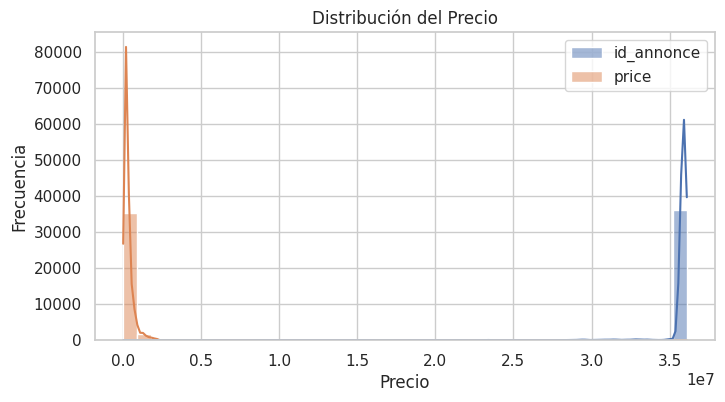

Curtosis: id_annonce    113.931897
price           8.329033
dtype: float64
Skewness: id_annonce   -9.730898
price         2.518761
dtype: float64


In [16]:
# -----------------------------
# Distribución del precio
# -----------------------------
plt.figure(figsize=(8, 4))
sns.histplot(y, kde=True, bins=40)
plt.title("Distribución del Precio")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

print("Curtosis:", y.kurtosis())
print("Skewness:", y.skew())


* 4.2. Matriz de correlaciones

In [20]:
# Asegurarse de que y sea una Serie (1D)
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]

# Unimos X con y temporalmente
df_corr = X_imputed.copy()
df_corr["precio"] = y

# Filtrar solo columnas numéricas
df_corr_numeric = df_corr.select_dtypes(include=[np.number])

# Calcular matriz de correlaciones
corr_matrix = df_corr_numeric.corr()

# Correlaciones con el precio
correlaciones_target = corr_matrix["precio"].drop("precio").sort_values(ascending=False)

# Mostrar
print("Top correlaciones positivas:")
display(correlaciones_target.head(10))

print("Top correlaciones negativas:")
display(correlaciones_target.tail(10))


Top correlaciones positivas:


,precio
id_annonce,0.896271
nb_bathrooms,0.038300
nb_parking_places,0.037479
postal_code,0.037380
approximate_latitude,0.033954
has_a_balcony,0.028835
floor,0.016396
nb_terraces,0.014683
has_air_conditioning,0.004854
nb_boxes,0.004642


Top correlaciones negativas:


,precio
size,-0.007765
nb_bedrooms,-0.016456
energy_performance_value,-0.019380
land_size,-0.020617
nb_rooms,-0.021396
nb_photos,-0.027109
approximate_longitude,-0.031340
has_a_garage,-0.043235
last_floor,NaN
upper_floors,NaN


* 4.3. Visualización gráfica de correlaciones

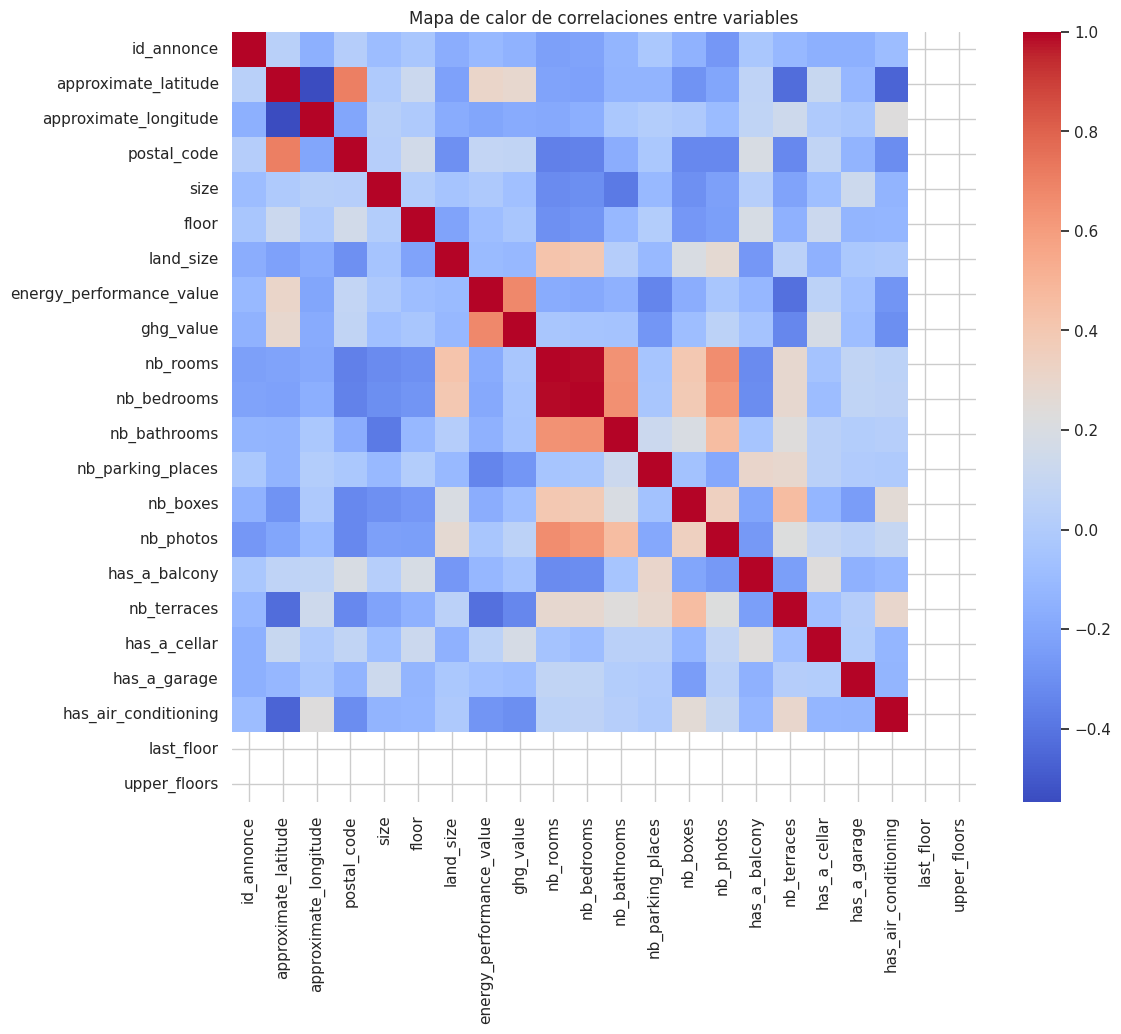

In [24]:
# -----------------------------
#  Mapa de calor (heatmap)
# -----------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[numeric_cols].corr(), cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Mapa de calor de correlaciones entre variables")
plt.show()


# Paso 5: Ingeniería de Features

* 5.1. Selección de variables explicativas

Elegimos las variables más correlacionadas con el precio (y) que obtuve en el paso anterior.

Por ejemplo, si las variables más útiles fueron:

In [22]:
features_seleccionadas = ["surface", "bedrooms", "zipcode", "energy_consumption", "greenhouse_emissions"]


* 5.2. Escalado de variables (normalización)

In [23]:
# -----------------------------
#  Escalado de variables
# -----------------------------
from sklearn.preprocessing import StandardScaler

# Ajustar esta lista a las variables más importantes
features_seleccionadas = correlaciones_target.head(10).index.tolist()

# Subconjunto de X
X_modelo = X_imputed[features_seleccionadas].copy()

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_modelo)

# Convertir de nuevo a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=features_seleccionadas)


* 5.3. (Opcional) Variables polinomiales

In [26]:
# -----------------------------
# Variables polinomiales (grado 2)
# -----------------------------
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Nuevos nombres de columnas
poly_columns = poly.get_feature_names_out(features_seleccionadas)

# Convertimos a DataFrame
X_poly = pd.DataFrame(X_poly, columns=poly_columns)


# Paso 6: División del conjunto de datos


Dependiendo si vas a usar X_scaled o X_poly:

Usa X_scaled si querés una regresión lineal o Huber básica.

Usa X_poly si vas a probar modelos polinómicos.


División 75 % / 25 %

In [28]:
# -----------------------------
# División del conjunto de datos
# -----------------------------
# Reemplazar X_scaled por X_poly si estás usando variables polinomiales
X_final = X_scaled  # o X_poly

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.25, random_state=42
)

# Confirmamos dimensiones
print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación:", X_test.shape, y_test.shape)


Entrenamiento: (28026, 10) (28026,)
Validación: (9342, 10) (9342,)


# Paso 7: Modelado

* 7.1. Modelo base – Regresión Lineal

In [29]:
# -----------------------------
#  Modelo base: Regresión Lineal
# -----------------------------
modelo_lineal = LinearRegression()
modelo_lineal.fit(X_train, y_train)

# Predicciones
y_pred_lineal = modelo_lineal.predict(X_test)


* Evaluación

In [33]:
# -----------------------------
# Evaluación del modelo
# -----------------------------
mse = mean_squared_error(y_test, y_pred_lineal)
mae = mean_absolute_error(y_test, y_pred_lineal)
r2 = r2_score(y_test, y_pred_lineal)

print(f" MSE: {mse:.2f}")
print(f" MAE: {mae:.2f}")
print(f" R²: {r2:.4f}")


 MSE: 507169837915.07
 MAE: 136467.49
 R²: 0.7882


* Interpretación de coeficientes

In [34]:
# -----------------------------
# Coeficientes del modelo
# -----------------------------
coeficientes = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": modelo_lineal.coef_
}).sort_values(by="Coeficiente", key=abs, ascending=False)

display(coeficientes)


,Variable,Coeficiente
0,id_annonce,1.305500e+06
4,approximate_latitude,-1.736322e+04
9,nb_boxes,9.250075e+03
6,floor,3.926036e+03
1,nb_bathrooms,3.417563e+03
5,has_a_balcony,3.148380e+03
3,postal_code,-2.707123e+03
8,has_air_conditioning,-1.476527e+03
2,nb_parking_places,-6.821081e+02
7,nb_terraces,-4.829404e+02


* 7.2. Modelo alternativo – Regresión de Huber

* Este modelo es más robusto frente a outliers.

In [38]:
# -----------------------------
#  Modelo alternativo: Huber
# -----------------------------
modelo_huber = HuberRegressor()
modelo_huber.fit(X_train, y_train)

# Predicciones
y_pred_huber = modelo_huber.predict(X_test)

# Evaluación
print(" Huber:")
print(f"MSE: {mean_squared_error(y_test, y_pred_huber):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_huber):.2f}")
print(f"R²: {r2_score(y_test, y_pred_huber):.4f}")


 Huber:
MSE: 728952368681.85
MAE: 65903.65
R²: 0.6955


# Paso 8: Comparación de resultados

* Tabla comparativa de desempeño

In [39]:
# -----------------------------
# Comparación de métricas
# -----------------------------
resultados = pd.DataFrame({
    "Modelo": ["Regresión Lineal", "Regresión Huber"],
    "MSE": [
        mean_squared_error(y_test, y_pred_lineal),
        mean_squared_error(y_test, y_pred_huber)
    ],
    "MAE": [
        mean_absolute_error(y_test, y_pred_lineal),
        mean_absolute_error(y_test, y_pred_huber)
    ],
    "R²": [
        r2_score(y_test, y_pred_lineal),
        r2_score(y_test, y_pred_huber)
    ]
})

display(resultados)


,Modelo,MSE,MAE,R²
0,Regresión Lineal,5.071698e+11,136467.488634,0.788157
1,Regresión Huber,7.289524e+11,65903.654652,0.695519


* Gráfico de dispersión: predicción vs valor real

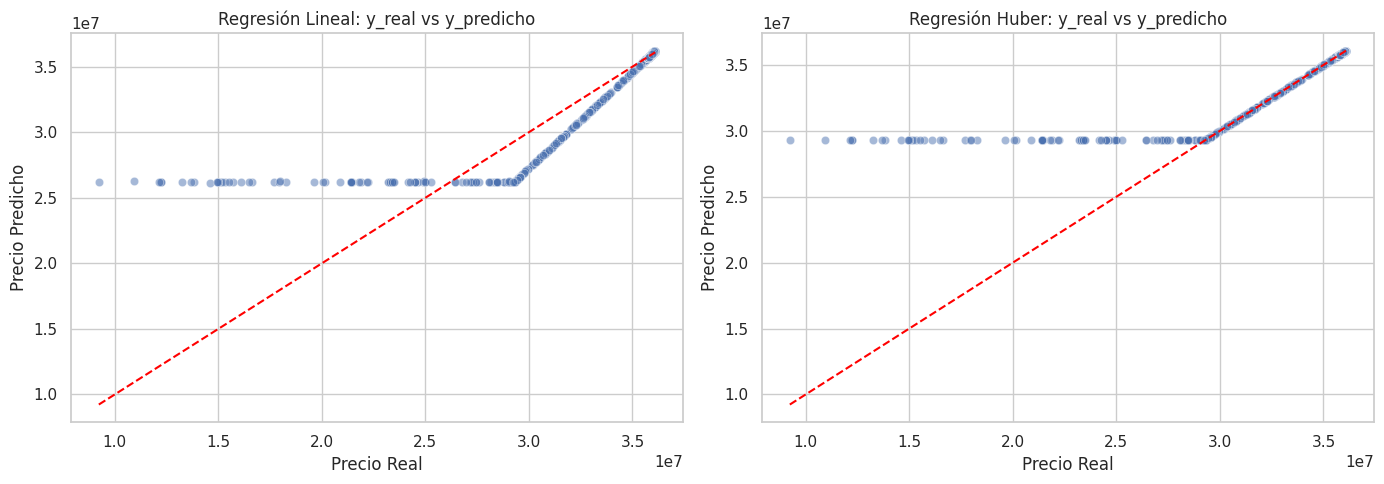

In [40]:
# -----------------------------
#  Visualización de predicciones
# -----------------------------
plt.figure(figsize=(14, 5))

# Lineal
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_lineal, alpha=0.5)
plt.title("Regresión Lineal: y_real vs y_predicho")
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')

# Huber
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_huber, alpha=0.5)
plt.title("Regresión Huber: y_real vs y_predicho")
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')

plt.tight_layout()
plt.show()


# Paso 9: Resumen ejecutivo final


Con el objetivo de predecir el precio de propiedades a partir de sus características estructurales y energéticas, se desarrolló un modelo de regresión sobre el dataset proporcionado. El proceso incluyó limpieza de datos, imputación de valores faltantes, detección y corrección de outliers, análisis de correlaciones y escalado de variables numéricas. A partir del análisis exploratorio, se seleccionaron las variables más influyentes y se evaluaron dos modelos: regresión lineal como base interpretativa, y regresión de Huber como alternativa robusta.

La regresión lineal obtuvo un coeficiente de determinación R² de **0.788** y un error absoluto medio (MAE) de **136,467**, lo que indica una buena capacidad explicativa del modelo. En cambio, la regresión de Huber logró un MAE significativamente menor de **65,904**, aunque con un R² más bajo de **0.696**. Si bien el modelo de Huber es más preciso frente a valores extremos, el modelo lineal es más interpretativo y globalmente explicativo.

Se recomienda su uso complementario según el contexto del análisis: interpretabilidad vs. precisión puntual.
